# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 6 - RNNs



**Harvard University**<br/>
**Fall 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner


<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

<span style="color:red">**Model training can be very slow; start doing this HW early**</span>

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below.
- Please restart the kernel and run the entire notebook again before you submit.

**Names of person you have worked with goes here:**
<br><BR>

<div class="theme"> Overview: Named Entity Recognition Challenge</div>

Named entity recognition (NER) seeks to locate and classify named entities present in unstructured text into predefined categories such as organizations, locations, expressions of times, names of persons, etc. This technique is often used in real use cases such as classifying content for news providers, efficient search algorithms over large corpora and content-based recommendation systems. 

This represents an interesting "many-to-many" problem, allowing us to experiment with recurrent architectures and compare their performances against other models.


In [2]:
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [3]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend

from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, TimeDistributed, GRU, \
                          Dropout, Bidirectional, Conv1D, BatchNormalization

print(tf.keras.__version__)
print(tf.__version__)

2.2.4-tf
2.0.0


In [4]:
# Set seed for repeatable results
np.random.seed(123)
tf.random.set_seed(456)

<div class="theme"> Part 1: Data </div>
Read `HW6_data.csv` into a pandas dataframe using the provided code below.

In [5]:
# Given code
path_dataset = './data/HW6_data.csv'
data = pd.read_csv(path_dataset,
                   encoding="latin1")
data = data.fillna(method="ffill")
data.head(15)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


As you can see, we have a dataset with sentences (```Sentence #``` column), each composed of words (```Word``` column) with part-of-speech tagging (```POS``` tagging) and inside–outside–beginning (IOB) named entity tags (```Tag``` column) attached. ```POS``` will not be used for this homework. We will predict ```Tag``` using only the words themselves.

Essential info about entities:
* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

IOB prefix:
* B: beginning of named entity
* I: inside of named entity
* O: outside of named entity


<div class='exercise'><b> Question 1: Data [20 points total]</b></div>

**1.1** Create a list of unique words found in the 'Word' column and sort it in alphabetic order. Then append the special word "ENDPAD" to the end of the list, and assign it to the variable ```words```. Store the length of this list as ```n_words```. **Print your results for `n_words`**

**1.2** Create a list of unique tags and sort it in alphabetic order. Then append the special word "PAD" to the end of the list, and assign it to the variable ```tags```. Store the length of this list as ```n_tags```. **Print your results for `n_tags`**

**1.3** Process the data into a list of sentences where each sentence is a list of (word, tag) tuples. Here is an example of how the first sentence in the list should look:

[('Thousands', 'O'),
 ('of',  'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]
 
**1.4** Find out the number of words in the longest sentence, and store it to variable ```max_len```. **Print your results for `max_len`.**

**1.5** It's now time to convert the sentences data in a suitable format for the RNNs training/evaluation procedures. Create a ```word2idx``` dictionary mapping distinct words from the dataset into distinct integers. Also create a ```idx2word``` dictionary.

**1.6** Prepare the predictors matrix ```X```, as a list of lists, where each inner list is a sequence of words mapped into integers accordly to the ```word2idx``` dictionary. 

**1.7** Apply the keras ```pad_sequences``` function to standardize the predictors. You should retrieve a matrix with all padded sentences and length equal to ```max_len``` previously computed. The dimensionality should therefore be equal to ```[# of sentences, max_len]```. Run the provided cell to print your results. Your ```X[i]``` now should be something similar to this:

`[ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]`
 
**1.8** Create a ```tag2idx``` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a ```idx2tag``` dictionary.

**1.9** Prepare targets matrix ```Y```, as a list of lists,where each inner list is a sequence of tags mapped into integers accordly to the ```tag2idx``` dictionary.

**1.10** apply the keras ```pad_sequences``` function to standardize the targets. Inject the ```PAD``` tag for the padding words. You should retrieve a matrix with all padded sentences'tags and length equal to ```max_length``` previously computed. 

**1.11** Use the ```to_categorical``` keras function to one-hot encode the tags. Now your ```Y``` should have dimension ```[# of sentences, max_len, n_tags]```. Run the provided cell to print your results.

**1.12** Split the dataset into train and test sets (test 10%).

## Answers

**1.1** Create a list of unique words found in the 'Word' column and sort it in alphabetic order. Then append the special word "ENDPAD" to the end of the list, and assign it to the variable ```words```. Store the length of this list as ```n_words```. **Print your results for `n_words`**

In [6]:
# your code here
# do not lower-case words
words = data['Word'].unique().tolist()
words.sort()
words.append("ENDPAD") # change in place, does not return appended list
n_words = len(words)

In [7]:
# Run this cell to show your results for n_words
print(n_words)

35179


**1.2** Create a list of unique tags and sort it in alphabetic order. Then append the special word "PAD" to the end of the list, and assign it to the variable ```tags```. Store the length of this list as ```n_tags```. **Print your results for `n_tags`**

In [8]:
# your code here
tags = data['Tag'].unique().tolist()
tags.sort()
tags.append("PAD")
n_tags = len(tags)

In [9]:
# Run this cell to show your results for n_tags
print(n_tags)

18


**1.3** Process the data into a list of sentences where each sentence is a list of (word, tag) tuples. Here is an example of how the first sentence in the list should look:

[('Thousands', 'O'),
 ('of',  'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]
 

In [10]:
# your code here
list_sentences = [list(zip(df.Word, df.Tag)) for _, df in data.groupby('Sentence #')]

In [11]:
len(list_sentences)

47959

**1.4** Find out the number of words in the longest sentence, and store it to variable ```max_len```. **Print your results for `max_len`.**

In [12]:
# your code here
max_len = data.groupby('Sentence #')[['Word']].count()['Word'].max()

In [13]:
# Run this cell to show your results for max_len
print(max_len)

104


**1.5** It's now time to convert the sentences data in a suitable format for the RNNs training/evaluation procedures. Create a ```word2idx``` dictionary mapping distinct words from the dataset into distinct integers. Also create a ```idx2word``` dictionary.

In [14]:
# your code here
word2idx = {w: words.index(w) for w in words}
idx2word = {words.index(w): w for w in words}

**1.6** Prepare the predictors matrix ```X```, as a list of lists, where each inner list is a sequence of words mapped into integers accordly to the ```word2idx``` dictionary. 

In [15]:
# your code here
X = [[word2idx[t[0]] for t in sentence] for sentence in list_sentences]

**1.7** Apply the keras ```pad_sequences``` function to standardize the predictors. You should retrieve a matrix with all padded sentences and length equal to ```max_len``` previously computed. The dimensionality should therefore be equal to ```[# of sentences, max_len]```. Run the provided cell to print your results. Your ```X[i]``` now should be something similar to this:

`[ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]`

In [16]:
# your code here
X = pad_sequences(X, maxlen = max_len, padding='post', value = n_words - 1)

In [17]:
# Run this cell to show your results #
print("The index of word 'Harvard' is: {}\n".format(word2idx["Harvard"]))
print("Sentence 1: {}\n".format(X[1]))
print(X.shape)

The index of word 'Harvard' is: 7506

Sentence 1: [ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]

(47959, 104)


**1.8** Create a ```tag2idx``` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a ```idx2tag``` dictionary.

In [18]:
# your code here
tag2idx = {t: tags.index(t) for t in tags}
idx2tag = {tags.index(t): t for t in tags}

**1.9** Prepare targets matrix ```Y```, as a list of lists,where each inner list is a sequence of tags mapped into integers accordly to the ```tag2idx``` dictionary.

In [19]:
# your code here
Y = [[tag2idx[t[1]] for t in sentence] for sentence in list_sentences]

**1.10** apply the keras ```pad_sequences``` function to standardize the targets. Inject the ```PAD``` tag for the padding words. You should retrieve a matrix with all padded sentences'tags and length equal to ```max_length``` previously computed. 

In [20]:
# your code here
Y = pad_sequences(Y, maxlen = max_len, padding='post', value = n_tags - 1)

**1.11** Use the ```to_categorical``` keras function to one-hot encode the tags. Now your ```Y``` should have dimension ```[# of sentences, max_len, n_tags]```. Run the provided cell to print your results.

In [21]:
# your code here
y = to_categorical(Y, num_classes = n_tags)

In [22]:
# Run this cell to show your results #
print("The index of tag 'B-gpe' is: {}\n".format(tag2idx["B-gpe"]))
print("The tag of the last word in Sentence 1: {}\n".format(y[0][-1]))
print(np.array(y).shape)

The index of tag 'B-gpe' is: 3

The tag of the last word in Sentence 1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

(47959, 104, 18)


**1.12** Split the dataset into train and test sets (test 10%).

In [23]:
# your code here
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(X, y, range(X.shape[0]), test_size=0.1)

## Part 2: Modelling

After preparing the train and test sets, we are ready to build five models: 
* frequency-based baseline 
* vanilla feedforward neural network
* recurrent neural network
* gated recurrent neural network
* bidirectional gated recurrent neural network

More details are given about architecture in each model's section. The input/output dimensionalities will be the same for all models:
* input: ```[# of sentences, max_len]```
* output: ```[# of sentences, max_len, n_tags]```

Follow the information in each model's section to set up the architecture of each model. And the end of each training, use the given ```store_model``` function to store the weights and architectures in the ```./models``` path for later testing;```load_keras_model()``` is also provided to you

A further ```plot_training_history``` helper function is given in case you need to check the training history.


In [24]:
# Store model
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("./models/{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./models/{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")
    
# Plot history
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [25]:
# Load model 
def load_keras_model(model_name):
    # Load json and create model
    json_file = open('./models/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = tf.keras.models.model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./models/{}.h5".format(model_name))
    return model

<div class='exercise'><b>Question 2: Models [40 points total]</b></div>

**2.1** **Model 1: Baseline Model**

Predict the tag of a word simply with the most frequently-seen named entity tag of this word from the training set.

e.g. word "Apple" appears 10 times in the training set; 7 times it was tagged as "Corporate" and 3 times it was tagged as "Fruit". If we encounter the word "Apple" in the test set, we predict it as "Corporate".

**Create an np.array ```baseline``` of length [n_words]**
where the ith element   ```baseline[i]``` is the index of the most commonly seen named entity tag of word i summarised from training set.   (e.g. [16, 16, 16, ..., 0, 16, 16])


**2.2** **Model 2: Vanilla Feed Forward Neural Network**

This model is provided for you. Please pay attention to the architecture of this neural network, especially the input/output dimensionalities and the Embedding layer.


**2.2a** Explain what the embedding layer is and why we need it here.

**2.2b** Explain why the Param # of Embedding layer is 1758950 (as shown in `print(model.summary())`).

**2.3** **Model 3: RNN**

Set up a simple RNN model by stacking the following layers in sequence:

    an input layer
    a simple Embedding layer transforming integer words into vectors
    a dropout layer to regularize the model
    a SimpleRNN layer
    a TimeDistributed layer with an inner Dense layer which output dimensionality is equal to n_tag
    
*(For hyperparameters, use those provided in Model 2)*

**2.3a** Define, compile, and train an RNN model. Use the provided code to save the model and plot the training history.

**2.3b** Visualize outputs from the SimpleRNN layer, one subplot for B-tags and one subplot for I-tags. Comment on the patterns you observed.

**2.4** **Model 4: GRU**

**2.4a** Briefly explain what a GRU is and how it's different from a simple RNN.

**2.4b** Define, compile, and train a GRU architecture by replacing the SimpleRNN cell with a GRU one. Use the provided code to save the model and plot the training history.

**2.4c** Visualize outputs from GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

**2.5** **Model 5: Bidirectional GRU**

**2.5a** Explain how a Bidirectional GRU differs from GRU model above.

**2.5b** Define, compile, and train a bidirectional GRU by wrapping your GRU layer in a Bidirectional one. Use the provided code to save the model and plot the training history.

**2.5c** Visualize outputs from bidirectional GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

## Answers

**2.1** **Model 1: Baseline Model**

Predict the tag of a word simply with the most frequently-seen named entity tag of this word from the training set.

e.g. word "Apple" appears 10 times in the training set; 7 times it was tagged as "Corporate" and 3 times it was tagged as "Fruit". If we encounter the word "Apple" in the test set, we predict it as "Corporate".

**Create an np.array ```baseline``` of length [n_words]**
where the ith element   ```baseline[i]``` is the index of the most commonly seen named entity tag of word i summarised from training set.   (e.g. [16, 16, 16, ..., 0, 16, 16])


[stack overflow](https://stackoverflow.com/questions/9850954/pandas-get-most-recent-value-of-a-particular-column-indexed-by-another-column/21007047#21007047)

In [26]:
# your code here
# count frequency of tags for each word
word_tag = pd.DataFrame({'X': X_train.flatten(), 'Y': Y[train_idx, :].flatten()})
count_by_word = word_tag.groupby(['X', 'Y']).size().reset_index(name = 'count')
# sort by word and frequency of tag in ascending order and only keep the last row for each word
count_by_word.sort_values(['X', 'count'], inplace = True)
count_by_word.drop_duplicates('X', keep = 'last', inplace = True)
# fill in tag frequency
baseline= np.array([tag2idx['O']]*n_words)
for word_idx in count_by_word['X']:
    baseline[word_idx] = count_by_word.loc[count_by_word['X'] == word_idx, 'Y']

In [27]:
# Run this cell to show your results #
print(baseline[X].shape,'\n')
print('Sentence:\n {}\n'.format([idx2word[w] for w in X[0]]))
print('Predicted Tags:\n {}'.format([idx2tag[i] for i in baseline[X[0]]]))

(47959, 104) 

Sentence:
 ['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDP

**2.2** **Model 2: Vanilla Feed Forward Neural Network**

This model is provided for you. Please pay attention to the architecture of this neural network, especially the input/output dimensionalities and the Embedding layer.


**embedding layer**:
- input_dim: Size of the vocabulary, i.e. maximum integer index + 1.
- output_dim: int >= 0. Dimension of the dense embedding.
- input_length: Length of input sequences (our padded sentence's length = max_len = 104)

the model will take as input an integer matrix of size (batch, input_length).
the largest integer (i.e. word index) in the input should be no larger vocabulary size
```
model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len)))
```

- Input shape: 2D tensor with shape: (batch_size, input_length).
- Output shape: 3D tensor with shape: (batch_size, input_length, output_dim).

### Use these hyperparameters for all NN models

In [28]:
n_units = 100
drop_rate = .1
dim_embed = 50

optimizer = "rmsprop"
loss = "categorical_crossentropy"
metrics = ["accuracy"]

batch_size = 32
epochs = 10
validation_split = 0.1
verbose = 1

In [29]:
# Define model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(tf.keras.layers.Dense(n_tags, activation="softmax"))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [30]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 50)           1758950   
_________________________________________________________________
dropout (Dropout)            (None, 104, 50)           0         
_________________________________________________________________
dense (Dense)                (None, 104, 18)           918       
Total params: 1,759,868
Trainable params: 1,759,868
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
# Train model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 17s 447us/sample - loss: 0.3147 - accuracy: 0.9786 - val_loss: 0.0602 - val_accuracy: 0.9858
Epoch 2/10
38846/38846 [==============================] - 16s 414us/sample - loss: 0.0514 - accuracy: 0.9863 - val_loss: 0.0477 - val_accuracy: 0.9868
Epoch 3/10
38846/38846 [==============================] - 16s 409us/sample - loss: 0.0451 - accuracy: 0.9872 - val_loss: 0.0449 - val_accuracy: 0.9875
Epoch 4/10
38846/38846 [==============================] - 17s 426us/sample - loss: 0.0428 - accuracy: 0.9877 - val_loss: 0.0435 - val_accuracy: 0.9878
Epoch 5/10
38846/38846 [==============================] - 16s 420us/sample - loss: 0.0415 - accuracy: 0.9881 - val_loss: 0.0427 - val_accuracy: 0.9880
Epoch 6/10
38846/38846 [==============================] - 16s 409us/sample - loss: 0.0406 - accuracy: 0.9883 - val_loss: 0.0423 - val_accuracy: 0.9882
Epoch 7/10
38846/38846 [=====================

In [34]:
store_keras_model(model, 'model_FFNN')

Saved model to disk


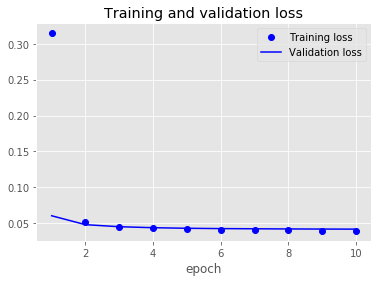

In [35]:
plot_training_history(history)

**2.2a** Explain what the embedding layer is and why we need it here.

*your answer here*

A embedding layer transforms each unique word to a fixed-length vector with continuous values, and similarity between words corresponds to similarity between their embedding vectors.

Similarity between words can be established and the embedding vector is much smaller than a one-hot encoding vector.

**2.2b** Explain why the Param # of Embedding layer is 1758950 (as shown in `print(model.summary())`).

*your answer here*

The number of parameters = vocabulary size * dimension of embedding, as we map each word to a vector of length `dim_embed`.

### Viewing Hidden Layers
In addition to the final result, we also want to see the intermediate results from hidden layers. Below is an example showing how to get outputs from a hidden layer, and visualize them on the reduced dimension of 2D by PCA. (**Please note that this code and the parameters cannot be simply copied and pasted for other questions; some adjustments need to be made**) 

In [40]:
FFNN = load_keras_model("model_FFNN")
def create_truncated_model_FFNN(trained_model):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
    model.add(tf.keras.layers.Dropout(drop_rate))
    # set weights of first few layers using the weights of trained model
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model
truncated_model = create_truncated_model_FFNN(FFNN)
hidden_features = truncated_model.predict(X_test)

# flatten data
hidden_features = hidden_features.reshape(-1,50)
 
# find first two PCA components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(hidden_features)
print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

Variance explained by PCA: 0.9409277605244746


In [45]:
# visualize hidden featurs on first two PCA components
# this plot only shows B-tags
def visualize_hidden_features(pca_result):
    color=['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = np.argmax(y_test, axis=1)
    fig, ax = plt.subplots()
    fig.set_size_inches(6,6)    
    for cat in range(8):
        indices_B = np.where(category==cat)[0]
        #length=min(1000,len(indices_B))
        #indices_B=indices_B[:length]
        ax.scatter(pca_result[indices_B,0], pca_result[indices_B, 1], label=idx2tag[cat],s=2,color=color[cat],alpha=0.5)
        legend=ax.legend(markerscale=3)
        legend.get_frame().set_facecolor('w')  
    plt.show()

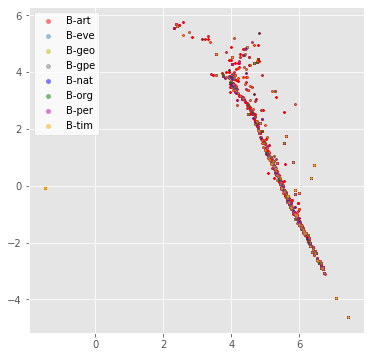

In [46]:
visualize_hidden_features(pca_result)

### Full function for other questions ###

In [47]:
def get_hidden_output_PCA(model,X_te,y_te,layer_index,out_dimension):
    output = tf.keras.backend.function([model.layers[0].input],[model.layers[layer_index].output])
    hidden_feature=np.array(output([X_te]))
    hidden_feature=hidden_feature.reshape(-1,out_dimension)
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(hidden_feature)
    print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))
    return pca_result

In [50]:
def visualize_B_I(pca_result):
    color = ['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = np.argmax(y_test.reshape(-1,18), axis=1)
    fig, ax = plt.subplots(1,2) 
    fig.set_size_inches(12,6)
    for i in range(2):
        for cat in range(8*i,8*(i+1)):
            indices = np.where(category==cat)[0]
            ax[i].scatter(pca_result[indices,0], pca_result[indices, 1], label=idx2tag[cat],s=2,color=color[cat-8*i],alpha=0.5)
        legend = ax[i].legend(markerscale=3)
        legend.get_frame().set_facecolor('w') 
        ax[i].set_xlabel("first dimension")
        ax[i].set_ylabel("second dimension")
    fig.suptitle("visualization of hidden feature on reduced dimension by PCA")
    
    plt.show()

Variance explained by PCA: 0.940932883482546


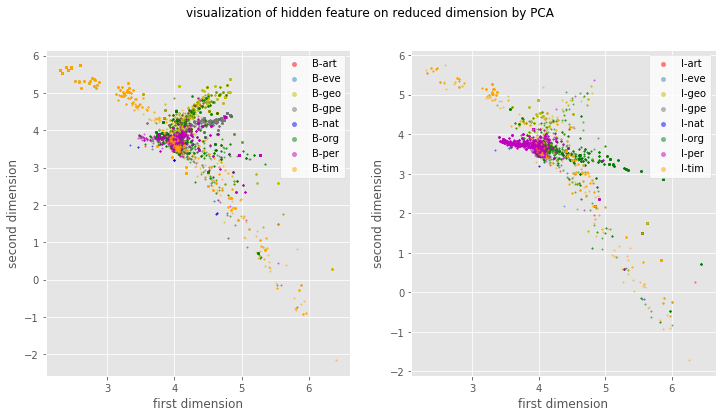

In [51]:
h = get_hidden_output_PCA(FFNN,X_test,y_test,1,50)
visualize_B_I(h)

**2.3** **Model 3: RNN**

Set up a simple RNN model by stacking the following layers in sequence:

    an input layer
    a simple Embedding layer transforming integer words into vectors
    a dropout layer to regularize the model
    a SimpleRNN layer
    a TimeDistributed layer with an inner Dense layer which output dimensionality is equal to n_tag
    
*(For hyperparameters, use those provided in Model 2)*

**2.3a** Define, compile, and train an RNN model. Use the provided code to save the model and plot the training history.

In [94]:
# your code here
n_units = 100
drop_rate = .1
dim_embed = 50
# Define model
simpleRNN = tf.keras.Sequential()
simpleRNN.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
simpleRNN.add(Dropout(drop_rate))
# add "return_sequences=True" to the simpleRNN layer before passing it to the TimeDistributed layer, 
# this should take care of your shape issues
simpleRNN.add(SimpleRNN(n_units, return_sequences=True))
simpleRNN.add(TimeDistributed(Dense(n_tags, activation="softmax")))

# Compile model
simpleRNN.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Train model
history_RNN = simpleRNN.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 81s 2ms/sample - loss: 0.0993 - accuracy: 0.9759 - val_loss: 0.0330 - val_accuracy: 0.9902
Epoch 2/10
38846/38846 [==============================] - 80s 2ms/sample - loss: 0.0294 - accuracy: 0.9912 - val_loss: 0.0288 - val_accuracy: 0.9915
Epoch 3/10
38846/38846 [==============================] - 80s 2ms/sample - loss: 0.0262 - accuracy: 0.9922 - val_loss: 0.0279 - val_accuracy: 0.9917
Epoch 4/10
38846/38846 [==============================] - 80s 2ms/sample - loss: 0.0244 - accuracy: 0.9927 - val_loss: 0.0269 - val_accuracy: 0.9919
Epoch 5/10
38846/38846 [==============================] - 80s 2ms/sample - loss: 0.0232 - accuracy: 0.9930 - val_loss: 0.0268 - val_accuracy: 0.9920
Epoch 6/10
38846/38846 [==============================] - 80s 2ms/sample - loss: 0.0220 - accuracy: 0.9934 - val_loss: 0.0264 - val_accuracy: 0.9920
Epoch 7/10
38846/38846 [==============================] -

In [95]:
# save your mode #
store_keras_model(simpleRNN, 'model_RNN')

Saved model to disk


In [96]:
# run this cell to show your results #
print(simpleRNN.summary())

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 104, 50)           1758950   
_________________________________________________________________
dropout_21 (Dropout)         (None, 104, 50)           0         
_________________________________________________________________
simple_rnn_19 (SimpleRNN)    (None, 104, 100)          15100     
_________________________________________________________________
time_distributed_9 (TimeDist (None, 104, 18)           1818      
Total params: 1,775,868
Trainable params: 1,775,868
Non-trainable params: 0
_________________________________________________________________
None


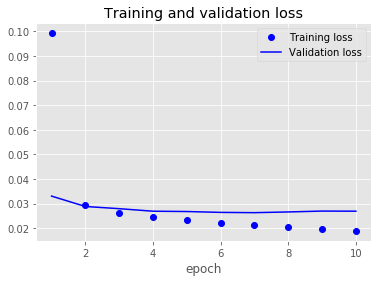

In [97]:
# run this cell to show your results #
plot_training_history(history_RNN)

**2.3b** Visualize outputs from the SimpleRNN layer, one subplot for B-tags and one subplot for I-tags. Comment on the patterns you observed.

Variance explained by PCA: 0.8397104286692739


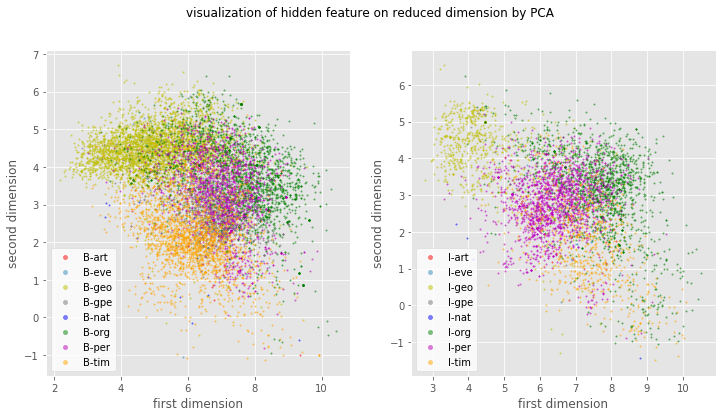

In [108]:
# your code here
h_RNN = get_hidden_output_PCA(simpleRNN,X_test,y_test,layer_index = 2,out_dimension = n_units)
visualize_B_I(h_RNN)

The clusters for B-tags and I-tags have 4 obviously separated clusters, but other 5 tags are overlapped with each other. RNN's hidden feature space are much more separated with less gaps, while FFNN's hidden feature space has has a lot of gaps and most tags are overlapped. 

<div class='explication'> </div>

**2.4** **Model 4: GRU**

**2.4a** Briefly explain what a GRU is and how it's different from a simple RNN.

[GRU](https://d2l.ai/chapter_recurrent-modern/gru.html)

*your answer here*
Gated Recurrent Unit has a reset state that enables us to calculate a new candidate hidden state based on the old one. It also has an update state calculate the new hidden state based on the old one and the candidate hidden state. The reset state gates help capture short-term dependencies, while the update gates help capture long-term dependencies in the sequences.

**2.4b** Define, compile, and train a GRU architecture by replacing the SimpleRNN cell with a GRU one. Use the provided code to save the model and plot the training history.

In [114]:
# your code here
# Define model
gru = tf.keras.Sequential()
gru.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
gru.add(Dropout(drop_rate))
gru.add(GRU(n_units, return_sequences=True))
gru.add(TimeDistributed(Dense(n_tags, activation="softmax")))

# Compile model
gru.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Train model
history_gru = gru.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 45s 1ms/sample - loss: 0.0884 - accuracy: 0.9778 - val_loss: 0.0324 - val_accuracy: 0.9905
Epoch 2/10
38846/38846 [==============================] - 40s 1ms/sample - loss: 0.0290 - accuracy: 0.9914 - val_loss: 0.0281 - val_accuracy: 0.9917
Epoch 3/10
38846/38846 [==============================] - 40s 1ms/sample - loss: 0.0257 - accuracy: 0.9924 - val_loss: 0.0268 - val_accuracy: 0.9920
Epoch 4/10
38846/38846 [==============================] - 40s 1ms/sample - loss: 0.0238 - accuracy: 0.9929 - val_loss: 0.0260 - val_accuracy: 0.9922
Epoch 5/10
38846/38846 [==============================] - 40s 1ms/sample - loss: 0.0226 - accuracy: 0.9932 - val_loss: 0.0260 - val_accuracy: 0.9923
Epoch 6/10
38846/38846 [==============================] - 40s 1ms/sample - loss: 0.0215 - accuracy: 0.9936 - val_loss: 0.0254 - val_accuracy: 0.9923
Epoch 7/10
38846/38846 [==============================] -

In [115]:
# save your model #
store_keras_model(gru, 'model_GRU')

Saved model to disk


In [116]:
# run this cell to show your results #
print(gru.summary())

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 104, 50)           1758950   
_________________________________________________________________
dropout_27 (Dropout)         (None, 104, 50)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 104, 100)          45600     
_________________________________________________________________
time_distributed_11 (TimeDis (None, 104, 18)           1818      
Total params: 1,806,368
Trainable params: 1,806,368
Non-trainable params: 0
_________________________________________________________________
None


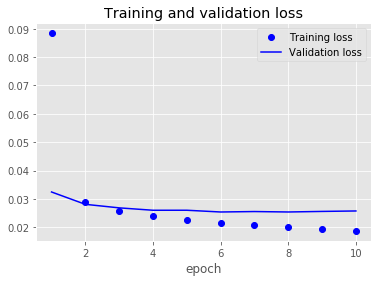

In [117]:
# run this cell to show your results #
plot_training_history(history_gru)

**2.4c** Visualize outputs from GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

Variance explained by PCA: 0.8127298617177465


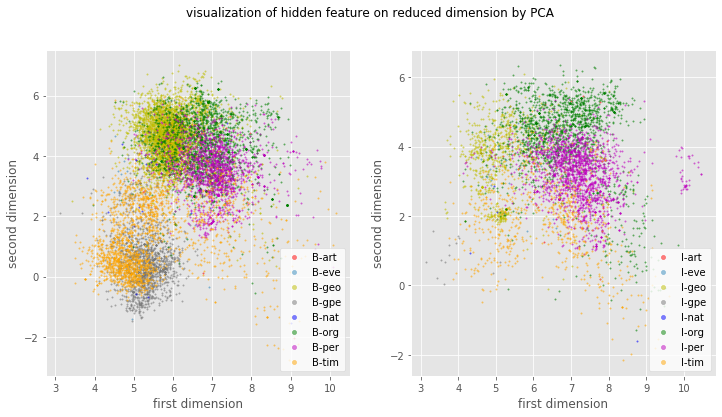

In [118]:
# your code here
h_gru = get_hidden_output_PCA(gru,X_test,y_test,layer_index = 2,out_dimension = n_units)
visualize_B_I(h_gru)

*your answer here*

The cluster for each tag is more separated, as we can see thre are at 5 obviously separated blusters for B tags and 4 for I tags.

**2.5** **Model 5: Bidirectional GRU**

**2.5a** Explain how a Bidirectional GRU differs from GRU model above.

*your answer here*

For a Bidirectional GRU, we consider two separate sequences: one from left to right and one from right to left. Each one takes input and output hidden states. Two hidden states at the same time stamp are combines to produce the output.

**2.5b** Define, compile, and train a bidirectional GRU by wrapping your GRU layer in a Bidirectional one. Use the provided code to save the model and plot the training history.


In [119]:
# your code here
# Define model
bi_gru = tf.keras.Sequential()
bi_gru.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
bi_gru.add(Dropout(drop_rate))
bi_gru.add(Bidirectional(GRU(n_units, return_sequences=True)))
bi_gru.add(TimeDistributed(Dense(n_tags, activation="softmax")))

# Compile model
bi_gru.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Train model
history_bi_gru = bi_gru.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 76s 2ms/sample - loss: 0.0728 - accuracy: 0.9818 - val_loss: 0.0282 - val_accuracy: 0.9917
Epoch 2/10
38846/38846 [==============================] - 71s 2ms/sample - loss: 0.0242 - accuracy: 0.9929 - val_loss: 0.0239 - val_accuracy: 0.9929
Epoch 3/10
38846/38846 [==============================] - 71s 2ms/sample - loss: 0.0209 - accuracy: 0.9938 - val_loss: 0.0228 - val_accuracy: 0.9932
Epoch 4/10
38846/38846 [==============================] - 71s 2ms/sample - loss: 0.0189 - accuracy: 0.9944 - val_loss: 0.0220 - val_accuracy: 0.9934
Epoch 5/10
38846/38846 [==============================] - 71s 2ms/sample - loss: 0.0177 - accuracy: 0.9948 - val_loss: 0.0219 - val_accuracy: 0.9934
Epoch 6/10
38846/38846 [==============================] - 71s 2ms/sample - loss: 0.0165 - accuracy: 0.9951 - val_loss: 0.0217 - val_accuracy: 0.9936
Epoch 7/10
38846/38846 [==============================] -

In [120]:
# save your model #
store_keras_model(bi_gru, 'model_BiGRU')

Saved model to disk


In [121]:
# run this cell to show your results #
print(bi_gru.summary())

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 104, 50)           1758950   
_________________________________________________________________
dropout_28 (Dropout)         (None, 104, 50)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 200)          91200     
_________________________________________________________________
time_distributed_12 (TimeDis (None, 104, 18)           3618      
Total params: 1,853,768
Trainable params: 1,853,768
Non-trainable params: 0
_________________________________________________________________
None


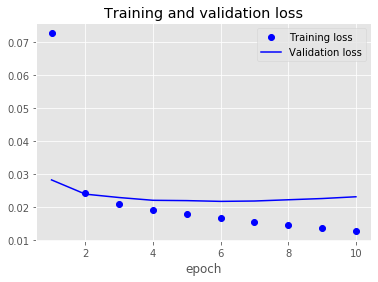

In [122]:
# run this cell to show your results #
plot_training_history(history_bi_gru)

**2.5c** Visualize outputs from bidirectional GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

Variance explained by PCA: 0.8452121896323468


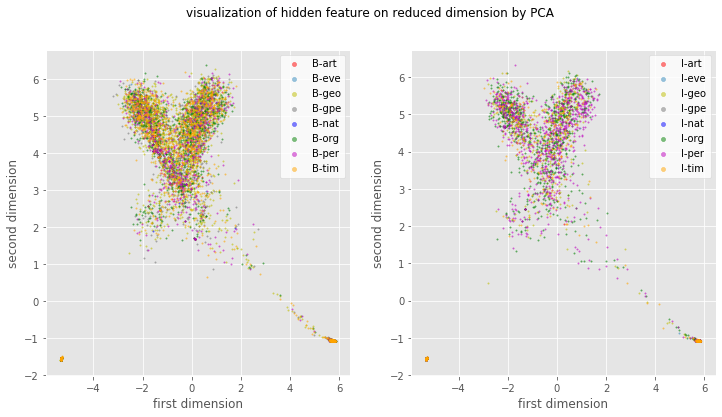

In [124]:
# your code here
h_bi_gru = get_hidden_output_PCA(bi_gru,X_test,y_test,layer_index = 2,out_dimension = n_units)
visualize_B_I(h_bi_gru)

*your answer here*

The bidirectional GRU's hidden feature space is mixed together.

<div class='exercise'><b> Question 3: Analysis [40pt]</b></div>


**3.1** For each model, iteratively:

- Load the model using the given function ```load_keras_model```

- Apply the model to the test dataset

- Compute an F1 score for each ```Tag``` and store it 

**3.2** Plot the F1 score per Tag and per model making use of a grouped barplot.

**3.3** Briefly discuss the performance of each model


**3.4** Which tags have the lowest f1 score? For instance, you may find from the plot above that the test accuracy on "B-art", and "I-art" are very low (just an example, your case maybe different). Here is an example when models failed to predict these tags right

<img src="data/B_art.png" alt="drawing" width="600"/>

**3.5** Write functions to output another example in which the tags of the lowest accuracy was predicted wrong in a sentence (include both "B-xxx" and "I-xxx" tags). Store the results in a DataFrame (same format as the above example) and use styling functions below to print out your df.

**3.6** Choose one of the most promising models you have built, improve this model to achieve an f1 score higher than 0.8 for as many tags as possible (you have lots of options here, e.g. data balancing, hyperparameter tuning, changing the structure of NN, a different optimizer, etc.)

**3.7** Explain why you chose to change certain elements of the model and how effective these adjustments were.


## Answers

**3.1** For each model, iteratively:

- Load the model using the given function ```load_keras_model```

- Apply the model to the test dataset

- Compute an F1 score for each ```Tag``` and store it 

In [28]:
# your code here
f1 = np.zeros((n_tags, 5)) # row: model, col: tag
# convert from one-hot encoding to correct tag index
y_true = y_test.argmax(axis = 2).flatten()
# baseline
baseline_test_pred = baseline[X_test].flatten()
# warning that not all not all your labels are included in your y_pred
f1[:, 0] = f1_score(y_true, baseline_test_pred, average = None)
# 4 models

models = ['model_FFNN', 'model_RNN', 'model_GRU', 'model_BiGRU']
for i, m_name in enumerate(models):
    m = load_keras_model(m_name)
    y_pred = m.predict(X_test).argmax(axis = 2).flatten()
    f1[:, i+1] = f1_score(y_true, y_pred, average = None)

/usr/share/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**3.2** Plot the F1 score per Tag and per model making use of a grouped barplot.

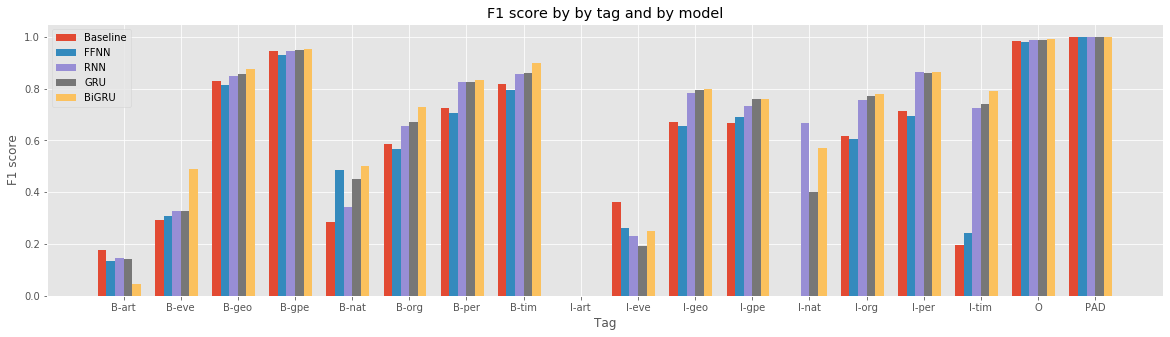

In [179]:
width = 0.15  # the width of the bars
ind = np.arange(n_tags)   # the x locations for the groups
labels = ['Baseline', 'FFNN', 'RNN', 'GRU', 'BiGRU']
fig, ax = plt.subplots(figsize=(20,5))
for i in range(5):
    ax.bar(ind + width*i, f1[:, i], width, label=labels[i])
# Set the labels for the x ticks
ax.set_xticks(ind + 2.5 * width)
ax.set_xticklabels(tags)
ax.set_xlabel('Tag')
ax.set_ylabel('F1 score')
ax.set_title('F1 score by by tag and by model')
plt.legend()
plt.show()

**3.3** Briefly discuss the performance of each model

*your answer here*

The baseline model has has comparable performance with feed-forward neural networks at most of the time, except for I-eve where the baseline model outperforms the FFNN. They both have poor formance on 'I-nat'.

For RNN, GRU, and BiGRU, they have similar performance, but BiGRU has the highest score in almost all cases. The only exceptions are B-art (BiGRU has the lowest score) and I-nat (RNN has the highest score).

**3.4** Which tags have the lowest f1 score? For instance, you may find from the plot above that the test accuracy on "B-art", and "I-art" are very low (just an example, your case maybe different). Here is an example when models failed to predict these tags right

<img src="data/B_art.png" alt="drawing" width="600"/>

*your answer here*

B-art", and "I-art" have the lowest f1 score

**3.5** Write functions to output another example in which the tags of the lowest accuracy was predicted wrong in a sentence (include both "B-xxx" and "I-xxx" tags). Store the results in a DataFrame (same format as the above example) and use styling functions below to print out your df.

In [46]:
def highlight_errors(s):
    is_max = s == s.y_true
    return ['' if v or key=='Word' else 'color: red' for key,v in is_max.iteritems()]

In [40]:
# your code here
# create data frame
df_pred = pd.DataFrame({'Word': [idx2word[idx] for idx in y_true], 'y_true': [idx2tag[idx] for idx in y_true]})
df_pred['baseline'] = [idx2tag[idx] for idx in baseline_test_pred]
for i, m_name in enumerate(models):
    m = load_keras_model(m_name)
    y_pred = m.predict(X_test).argmax(axis = 2).flatten()
    df_pred[m_name] = [idx2tag[idx] for idx in y_pred]

In [43]:
# your code here
# keep I-art and B-art
df_lowest_accu = df_pred.loc[(df_pred['y_true'] == 'B-art') | (df_pred['y_true'] == 'I-art'), :]

In [56]:
# your code here
B_art_idx = tag2idx['B-art']
I_art_idx = tag2idx['I-art']
y_test_matrix = y_test.argmax(axis = 2)


array([[ 6, 14, 16, ..., 17, 17, 17],
       [16, 16, 16, ..., 17, 17, 17],
       [16, 16, 16, ..., 17, 17, 17],
       ...,
       [16, 16, 16, ..., 17, 17, 17],
       [ 6, 16, 16, ..., 17, 17, 17],
       [16, 16, 16, ..., 17, 17, 17]])

In [51]:
np.unique([idx2tag[idx] for idx in y_true])

array(['B-art', 'B-eve', 'B-geo', 'B-gpe', 'B-nat', 'B-org', 'B-per',
       'B-tim', 'I-art', 'I-eve', 'I-geo', 'I-gpe', 'I-nat', 'I-org',
       'I-per', 'I-tim', 'O', 'PAD'], dtype='<U5')

**3.6** Choose one of the most promising models you have built, improve this model to achieve an f1 score higher than 0.8 for as many tags as possible (you have lots of options here, e.g. data balancing, hyperparameter tuning, changing the structure of NN, a different optimizer, etc.)

In [ ]:
# your code here


**3.7** Explain why you chose to change certain elements of the model and how effective these adjustments were.

*your answer here*